In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange 


In [17]:
import numpy as np
import pandas as pd

In [18]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()


# automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [22]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

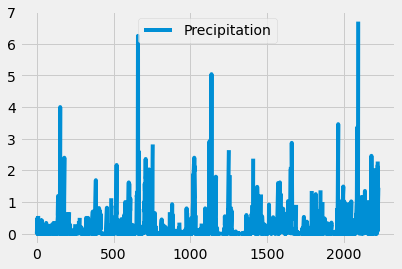

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# for row in session.query(Measurement, Measurement.date, Measurement.prcp).limit(330).all():
#     print(row)
    
#use delta
# today = dt.date.today()
# delta = dt.timedelta(days=365)
# today - delta

target_date = dt.date(2017, 8, 23)
delta= dt.timedelta(days=365)
query_date = target_date - delta

# session.query(Dow.date, Dow.close_price)\
#     .filter(Dow.date == query_date)\
#     .all()


h_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).order_by(Measurement.date.desc()).all()
h_prcp

h_prcp_df = pd.DataFrame(h_prcp, columns=['Date','Precipitation'])
h_prcp_df.head()
h_prcp_df.set_index('Date')

Year_prcp_df = h_prcp_df.sort_values(by='Date')
Year_prcp_df.head(10)
# h_prcp_df.sort_index(inplace=True)
# h_prcp_df.head(10)

# h_prcp_df.sort_index()

# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
Year_prcp_df.plot(x_compat=True)

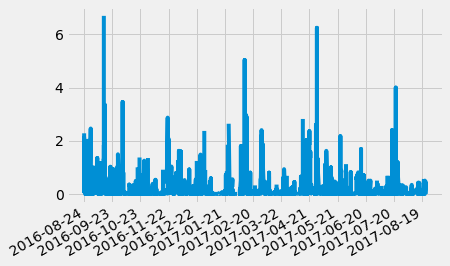

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt

# np.random.seed(1)

# N = 100
# y = np.random.rand(N)

# now = dt.datetime.now()
# then = now + dt.timedelta(days=100)
# days = mdates.drange(now,then,dt.timedelta(days=1))
Year_prcp_df = h_prcp_df.sort_values(by='Date')
Year_prcp_df.head(10)

dates = Year_prcp_df['Date']
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = Year_prcp_df["Precipitation"]

# range(len(x))


# target_date = dt.date(2017, 8, 23)
# delta= dt.timedelta(days=365)
# query_date = target_date - delta

# days = mdates.drange(query_date,target_date,dt.timedelta(days=1))
# y=Year_prcp_df["Precipitation"]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
# plt.xlabel('Date')
# plt.ylabel('Inches')

plt.tight_layout
plt.show()
plt.savefig('Precipitation.png')

plt.close()


In [27]:
Year_prcp_df = h_prcp_df.sort_values(by='Date')
Year_prcp_df.head(10)

,Date,Precipitation
2222,2016-08-24,1.45
2216,2016-08-24,0.08
2217,2016-08-24,2.15
2221,2016-08-24,2.15
2219,2016-08-24,NaN
2218,2016-08-24,2.28
2220,2016-08-24,1.22
2215,2016-08-25,0.11
2214,2016-08-25,0.06
2213,2016-08-25,0.21


In [28]:
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
# plt.plot(days,y)
# plt.gcf().autofmt_xdate()
# plt.show()

# date1 = datetime.datetime(2020, 4, 2) 
# date2 = datetime.datetime(2020, 4, 6) 
# delta = datetime.timedelta(hours = 6) 
# dates = drange(date1, date2, delta) 
#matplotlib.pyplot.plot_date(x, y, fmt='o', tz=None, xdate=True, ydate=False, hold=None, data=None, **kwargs 

# y = np.arange(len('Dates'))   
# y=
# x=
# fig, ax = plt.subplots() 
# ax.plot_date(x=Year_prcp_df['Date'], y=Year_prcp_df["Precipitation"], xdate=True, ydate=False) 


# ax=Year_prcp_df.plot(x_compat=True, rot=90)
ax.set_ylabel('Inches')
ax.set_xlabel('Dates')

# ax.set_xlim('Dates[0]', 'Dates[-1]') 

# ax.xaxis.set_major_formatter(DateFormatter('% Y-% m-% d')) 
# ax.fmt_xdata = DateFormatter('% Y-% m-% d % H:% M:% S') 
# fig.autofmt_xdate()


NameError: name 'ax' is not defined

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Year_prcp_df.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [30]:
# Design a query to show how many stations are available in this dataset?
# s_id = session.query(Station, Station.id).all()
session.query(func.count(Station.id)).all()

[(9)]

In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# same_genus = session.query(NA.genus, NA.species).join(EA, NA.genus == EA.genus).all()

# for record in same_genus:
#     na_genus, na_species = record
#     print('NA Genus:', na_genus, 'NA Species:', na_species)
# active_station = session.query(Measurement.station, Measurement.date).order_by(Measurement.station.desc()).all()

active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
active_station
active_station2 = session.query(Measurement.station).group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
active_station2
# active_station = session.query(Measurement.station, Measurement.date).join(Station, Measurement.station == Station.station).all()

# for record in active_station:
#     Measurement.station, Measurement.date = record
#     print("Station:", Measurement.station, "Date:", Measurement.date)

[('USC00519281'),
 ('USC00519397'),
 ('USC00513117'),
 ('USC00519523'),
 ('USC00516128'),
 ('USC00514830'),
 ('USC00511918'),
 ('USC00517948'),
 ('USC00518838')]

In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# session.query(Measurement.station, func.min(Measurement.tobs)).all()
# session.query(Measurement.station, func.max(Measurement.tobs)).all()
# session.query(Measurement.id, func.min(Measurement.tobs)).all()
# session.query('USC00519281', func.mean(Measurement.tobs)).all()

session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
.filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [33]:
#make a variable of the most active station and then the variable is [0,0]
# active_station
# session.query(active_station2[0], func.avg(Measurement.tobs)).all()

session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
.filter(Measurement.station==str(active_station2[0])).all()

[(None, None, None)]

In [34]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_temps = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
active_temps
session.query(Measurement.station =='USC00519281', Measurement.date, Measurement.tobs).order_by(Measurement.date.desc()).all()


[(False, '2017-08-23', 81.0),
 (False, '2017-08-23', 82.0),
 (False, '2017-08-23', 82.0),
 (False, '2017-08-23', 76.0),
 (False, '2017-08-22', 82.0),
 (False, '2017-08-22', 82.0),
 (False, '2017-08-22', 76.0),
 (False, '2017-08-21', 81.0),
 (False, '2017-08-21', 79.0),
 (False, '2017-08-21', 82.0),
 (False, '2017-08-21', 76.0),
 (False, '2017-08-20', 81.0),
 (False, '2017-08-20', 80.0),
 (False, '2017-08-20', 78.0),
 (False, '2017-08-19', 79.0),
 (False, '2017-08-19', 80.0),
 (False, '2017-08-19', 85.0),
 (False, '2017-08-19', 71.0),
 (False, '2017-08-18', 80.0),
 (False, '2017-08-18', 77.0),
 (True, '2017-08-18', 79.0),
 (False, '2017-08-18', 76.0),
 (False, '2017-08-17', 78.0),
 (False, '2017-08-17', 83.0),
 (True, '2017-08-17', 76.0),
 (False, '2017-08-17', 72.0),
 (False, '2017-08-16', 82.0),
 (False, '2017-08-16', 79.0),
 (True, '2017-08-16', 76.0),
 (False, '2017-08-16', 71.0),
 (False, '2017-08-15', 78.0),
 (False, '2017-08-15', 82.0),
 (False, '2017-08-15', 79.0),
 (True, '2017

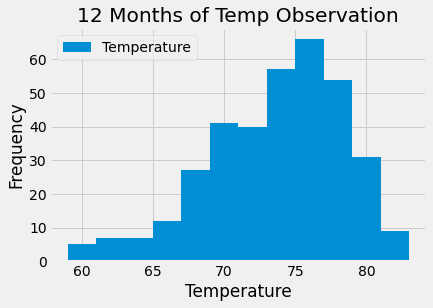

In [35]:
target_date = dt.date(2017, 8, 18)
delta= dt.timedelta(days=365)
query_date = target_date - delta

h_tob = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station=='USC00519281').\
    filter(Measurement.date > query_date).order_by(Measurement.date.desc()).all()
h_tob
h_tob_df = pd.DataFrame(h_tob, columns=['Date','Temperature'])
h_tob_df.head()

ax = h_tob_df.plot.hist(title="12 Months of Temp Observation", bins=12)
ax.set_xlabel('Temperature')
plt.tight_layout
plt.show()
plt.savefig('TempObservation.png')

plt.close()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
